In [1]:
#config
from sklearn import set_config
set_config(display = "diagram")

#built in
import os 

#HTML
from IPython.core.display import HTML

#data
import pandas as pd
import numpy as np

#preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, KBinsDiscretizer

#pipeline
from sklearn.pipeline import Pipeline, make_pipeline

#compose
from sklearn.compose import ColumnTransformer, make_column_transformer

#Estimator
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

#feature selection
from sklearn.feature_selection import VarianceThreshold

#model selection
from sklearn.model_selection import train_test_split, GridSearchCV

#metrics
from sklearn.metrics import r2_score,mean_squared_error, SCORERS

#clone
from sklearn.base import clone

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)

sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# 1 -Preparation des données

## 1.1 - Chargement

In [3]:
source = 'data/cleaned/'
filename = 'df_clean2.csv'
df = pd.read_csv(source + filename, index_col = 0)

In [4]:
df.shape

(2384, 43)

In [5]:
cond = df['ENERGYSTARScore'].isna()
rqdIndex = df[cond].index
df.drop(rqdIndex, axis = 0, inplace = True)

In [6]:
df.shape

(1646, 43)

### Fonction pour afficher les resultats dans une DF

In [7]:
#fonction qui renvoie la R2 et Rmse
def score_p(modele, X, y):
    y_pred = modele.predict(X)
    rmse = mean_squared_error(y, y_pred, squared = False).round(2)
    r2 = r2_score(y, y_pred).round(2)
    
    return rmse, r2

In [8]:
def add_result(df, data):
    df = df.copy()
    df = df.append(data,  ignore_index= True)
    return df

In [9]:
#fonction pour calculer le R2 et rmse
def summary( modele, df, X_train, X_test, y_train , y_test, 
            ensembliste = 'non',target ='TotalGHGEmissions',commentaires = ""):

    #recupération nom du modele
    nom_modele = modele[-1].__class__.__name__
    
    #Calcul du rmse et r2
    #train set
    train_rmse = score_p(modele, X_train, y_train)[0]
    train_r2 = score_p(modele, X_train, y_train)[1]
    
    #test set
    test_rmse = score_p(modele, X_test, y_test)[0]
    test_r2 = score_p(modele, X_test, y_test)[1]
    
    #On ajoute les données dans la DataFrame
    
    data = {'Modele' : nom_modele,'Ensembliste':ensembliste,'Target' : target,
               'Train_RMSE': train_rmse,'Test_RMSE' : test_rmse,'Train_R2' : train_r2,
               'Test_R2' : test_r2, 'Commentaires' : commentaires}
    df = add_result(df, data)
    return df

In [10]:
#Creation de la dataframe Summary
df_summary = pd.DataFrame(columns = ['Modele','Ensembliste','Target','Train_RMSE','Test_RMSE','Train_R2',
            'Test_R2', 'Commentaires'])
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires


### 1.2 Train test split

In [11]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'NonResidentialGFA', 'delta_Site_WM',
       'delta_Source_WM', 'Delta_Site_Source', 'Delta_Site_Source_WN',
       'ratio_Site_Source_WN', 'NaturalGaz

In [12]:
target = 'SourceEUIWN(kBtu/sf)'
cond = df['SourceEUIWN(kBtu/sf)']<0
df[cond]['SourceEUIWN(kBtu/sf)']

3206   -2.1
Name: SourceEUIWN(kBtu/sf), dtype: float64

In [13]:
df.drop(df[cond].index, axis = 0, inplace= True)

In [14]:
X = df.copy().drop([target], axis =1)
y = df.copy()[target]
y_trans = np.log1p(y)

In [15]:
#stratification des données
df['SourceEUIWN(kBtu/sf)_q'] = pd.qcut(df['SourceEUIWN(kBtu/sf)'],10)
df['SourceEUIWN(kBtu/sf)_q'].value_counts()

(61.04, 75.5]       166
(-0.001, 61.04]     165
(86.7, 95.8]        165
(123.74, 146.8]     165
(236.54, 2620.0]    165
(75.5, 86.7]        164
(107.1, 123.74]     164
(146.8, 180.52]     164
(180.52, 236.54]    164
(95.8, 107.1]       163
Name: SourceEUIWN(kBtu/sf)_q, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y_trans,
                                                    test_size =0.3,
                                                    random_state = 18,
                                                    shuffle = True,
                                                    stratify = df['SourceEUIWN(kBtu/sf)_q'])

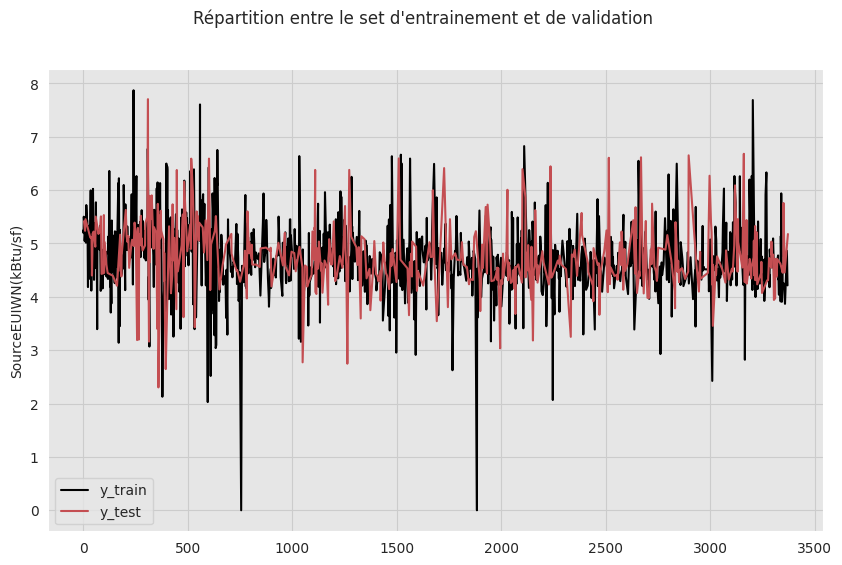

In [17]:
fig, ax = plt.subplots()
sns.lineplot(x=y_train.index, y= y_train, color ='black', label ='y_train', ax =ax)
sns.lineplot(x=y_test.index, y = y_test, color = sns_c[3], label ='y_test', ax=ax)
plt.suptitle("Répartition entre le set d'entrainement et de validation")
plt.show()

### 1.3 - Model Developpement

In [18]:
#features:
numeric_features = [
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'Electricity_p',
    'Latitude',
    'Longitude',
    'NonResidentialGFA',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'ENERGYSTARScore']


categorical_features = [
    'PrimaryPropertyType',
    'LargestPropertyUseType'
]

features = numeric_features + categorical_features

In [19]:
X_train = X_train[features]
X_test = X_test[features]

### 1.4 - Preprocessor

In [20]:
#centrage et réduction des données
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])

In [21]:
#transformation des variables categorielles
categorical_transformer = Pipeline(steps = [
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'))
])

In [22]:
#Recuperation des noms de colonnes apres les transformations
categorical_features_ext = list(categorical_transformer['one_hot']\
                                .fit(X_train[categorical_features])\
                                .get_feature_names_out()
                               )
features_ext = categorical_features_ext + numeric_features
print(f'Number of features after preprocessing: {len(features_ext)}')

Number of features after preprocessing: 50


## 2 - Model Selection

### 2.1 - Linear Model

### preprocessor

In [23]:
linear_preprocessor = ColumnTransformer(transformers = [
    ('cat', categorical_transformer, categorical_features),
    ('num', numeric_transformer, numeric_features),
], remainder = 'passthrough')

### engineering

In [24]:
#For linear regressor
linear_feature_engineering = Pipeline(steps = [
    ('linear_preprocessor', linear_preprocessor),
    ('polynomial', PolynomialFeatures(degree = 1, include_bias = False)),
    ('variance_threshold', VarianceThreshold())
])


### 2.1.1 - Dummy Regressor

In [25]:
dummy = Pipeline(steps = [
    ('linear_feature_engineering', linear_feature_engineering),
    ('regressor', DummyRegressor(strategy="mean"))
])

In [26]:

dummy.fit(X_train, y_train)
df_summary = summary(dummy, df_summary,X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,0.67,0.63,0.0,-0.0,


### 2.1.2 - Lasso

In [27]:
from sklearn.compose import TransformedTargetRegressor

In [28]:
lasso = Pipeline(steps = [
    ('linear_feature_engineering', linear_feature_engineering),
    ('regressor', Lasso(max_iter = 8000))
])



In [29]:
#Recherche des meilleurs hyperparametres
lasso_param_grid = {
    'linear_feature_engineering__polynomial__degree' : [1,2],
    'regressor__alpha' : np.logspace(-3,3,20),
    'linear_feature_engineering__polynomial__interaction_only' : [True, False]
}

lasso_grid_search = GridSearchCV(
    estimator = lasso,
    param_grid = lasso_param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv = 3,
    verbose = 1,
    n_jobs = -1
)

In [30]:
lasso_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('linear_feature_engineering',
                                        Pipeline(steps=[('linear_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'LargestPropertyUseType']),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['...
                         'regressor__alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])},
             scoring='neg_root_mean_squared_error', verbose=1)

In [31]:
lasso_grid_search.best_params_

{'linear_feature_engineering__polynomial__degree': 1,
 'linear_feature_engineering__polynomial__interaction_only': True,
 'regressor__alpha': 0.001}

In [32]:
lasso.set_params(**lasso_grid_search.best_params_).fit(X_train, y_train)

Pipeline(steps=[('linear_feature_engineering',
                 Pipeline(steps=[('linear_preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cat',
                                                                   Pipeline(steps=[('one_hot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['PrimaryPropertyType',
                                                                    'LargestPropertyUseType']),
                                                                  ('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['LargestPropertyUseTypeGFA',
                                                                    '...eTypeGFA',
                                                                    'ThirdLargestPropertyUseTypeGFA',
                                                                    'Electricity_p',
                                                                    'Latitude',
                                                                    'Longitude',
                                                                    'NonResidentialGFA',
                                                                    'PropertyGFAParking',
                                                                    'PropertyGFABuilding(s)',
                                                                    'ENERGYSTARScore'])])),
                                 ('polynomial',
                                  PolynomialFeatures(degree=1,
                                                     include_bias=False,
                                                     interaction_only=True)),
                                 ('variance_threshold', VarianceThreshold())])),
                ('regressor', Lasso(alpha=0.001, max_iter=8000))])

In [33]:
lasso.set_params(**lasso_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(lasso, df_summary,X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,0.67,0.63,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,


### 2.1.3 - Linear

In [34]:
linear = Pipeline(steps = [
    ('linear_feature_engineering', linear_feature_engineering),
    ('regressor', LinearRegression())
])

In [35]:
#Recherche des meilleurs hyperparametres
linear_param_grid = {
    'linear_feature_engineering__polynomial__degree' : [1,2,3],
    'regressor__fit_intercept': [True, False]
}

linear_grid_search = GridSearchCV(
    estimator = linear,
    param_grid = linear_param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv = 3,
    verbose = 2,
    n_jobs = -1
)

In [36]:
linear_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('linear_feature_engineering',
                                        Pipeline(steps=[('linear_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'LargestPropertyUseType']),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['...
                                                                                           'ENERGYSTARScore'])])),
                                                        ('polynomial',
                                                         PolynomialFeatures(degree=1,
                                                                            include_bias=False,
                                                                            interaction_only=True)),
                                                        ('variance_threshold',
                                                         VarianceThreshold())])),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1,
             param_grid={'linear_feature_engineering__polynomial__degree': [1,
                                                                            2,
                                                                            3],
                         'regressor__fit_intercept': [True, False]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [37]:
linear_grid_search.best_params_

{'linear_feature_engineering__polynomial__degree': 1,
 'regressor__fit_intercept': True}

In [38]:
linear.set_params(**linear_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(linear, df_summary,X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,0.67,0.63,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
2,LinearRegression,non,TotalGHGEmissions,0.37,0.32,0.70,0.74,


In [39]:
linear_y_pred = linear.predict(X_test)
residu_linear = y_test - linear_y_pred

### 2.1.4 - Ridge

In [40]:
ridge = Pipeline(steps = [
    ('linear_feature_engineering', linear_feature_engineering),
    ('regressor', Ridge())
])

In [41]:
#Recherche des meilleurs hyperparametres
ridge_param_grid = {
    'linear_feature_engineering__polynomial__degree' : [1,2,3],
    'regressor__fit_intercept': [True, False]
}

ridge_grid_search = GridSearchCV(
    estimator = ridge,
    param_grid = ridge_param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv = 3,
    verbose = 2,
    n_jobs = -1
)

In [42]:
ridge_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('linear_feature_engineering',
                                        Pipeline(steps=[('linear_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'LargestPropertyUseType']),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['...
                                                                                           'PropertyGFABuilding(s)',
                                                                                           'ENERGYSTARScore'])])),
                                                        ('polynomial',
                                                         PolynomialFeatures(degree=1,
                                                                            include_bias=False,
                                                                            interaction_only=True)),
                                                        ('variance_threshold',
                                                         VarianceThreshold())])),
                                       ('regressor', Ridge())]),
             n_jobs=-1,
             param_grid={'linear_feature_engineering__polynomial__degree': [1,
                                                                            2,
                                                                            3],
                         'regressor__fit_intercept': [True, False]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [43]:
ridge_grid_search.best_params_

{'linear_feature_engineering__polynomial__degree': 1,
 'regressor__fit_intercept': True}

In [44]:
ridge.set_params(**ridge_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(ridge, df_summary,X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,0.67,0.63,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
2,LinearRegression,non,TotalGHGEmissions,0.37,0.32,0.70,0.74,
3,Ridge,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,


### 2.2 - Decision Tree regressor

### preprocessor

In [45]:
tree_preprocessor = ColumnTransformer(transformers = [
    ('cat', categorical_transformer, categorical_features),
], remainder = 'passthrough')

### engineering

In [46]:
tree_feature_engineering = Pipeline(steps = [
    ('tree_preprocessor', tree_preprocessor),
])

In [47]:
tree = Pipeline(steps = [
    ('tree_feature_engineering', tree_feature_engineering),
    ('regressor', DecisionTreeRegressor())
])

In [48]:
#Recherche des meilleurs hyperparamètres
tree_param_grid = {'regressor__max_depth' : [30,40,50],
              'regressor__min_samples_leaf' : [1,3,5,10],
             }

tree_grid_search = GridSearchCV(
    estimator=tree,
    param_grid=tree_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs = -1,
    verbose = -1
)

In [49]:
tree_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree_feature_engineering',
                                        Pipeline(steps=[('tree_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'LargestPropertyUseType'])]))])),
                                       ('regressor', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [30, 40, 50],
                         'regressor__min_samples_leaf': [1, 3, 5, 10]},
             scoring='neg_root_mean_squared_error', verbose=-1)

In [50]:
tree_grid_search.best_params_

{'regressor__max_depth': 50, 'regressor__min_samples_leaf': 3}

In [51]:
tree.set_params(**tree_grid_search.best_params_).fit(X_train, y_train)
tree.score(X_test, y_test)

0.5203314556429908

In [52]:
tree.set_params(**tree_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(tree, df_summary,X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,0.67,0.63,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
2,LinearRegression,non,TotalGHGEmissions,0.37,0.32,0.70,0.74,
3,Ridge,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
4,DecisionTreeRegressor,non,TotalGHGEmissions,0.22,0.44,0.89,0.52,


## 2.3 - Methode ensembliste

## 2.3.1 Bagging

https://medium.com/towards-data-science/bagging-on-low-variance-models-38d3c70259db

https://medium.com/all-about-ml/bagging-random-forests-and-boosting-8c728e91a85d

### fonction pour gerer l'arret précoce

In [53]:
def arret_precoce(modele,X_train,y_train,X_test,y_test, n_estimators, n_error):
    min_val_error = float('inf')
    for n in range(1, n_estimators):
        modele.n_estimators = n
        modele.fit(X_train,y_train)
        val_error = mean_squared_error(y_test, modele.predict(X_test), squared= False)
        if min_val_error >= val_error:
            min_val_error = val_error
            error_going_up = 0
        else:
            error_going_up +=1
            if error_going_up > n_error :
                break
    
    print(f"n_estimators ={n} et rmse = {val_error: .2f}")
    return n

In [54]:
estimator = DecisionTreeRegressor()
bag_reg= BaggingRegressor(estimator, n_estimators = 500, max_samples = 0.1, bootstrap = True, n_jobs = -1)
modele = Pipeline(steps = [
    ('tree_feature_engineering', tree_feature_engineering),
    ('regressor', bag_reg)
])

In [55]:
arret_precoce(modele,X_train,y_train,X_test,y_test, 800, 40)

n_estimators =63 et rmse =  0.36


63

In [56]:
modele.set_params(regressor__n_estimators = 42).fit(X_train, y_train)
df_summary = summary(modele, df_summary,X_train, X_test, y_train, y_test,
                     ensembliste = "DecisionTreeRegressor",
                     commentaires = "avec arret précoce")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,0.67,0.63,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
2,LinearRegression,non,TotalGHGEmissions,0.37,0.32,0.70,0.74,
3,Ridge,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
4,DecisionTreeRegressor,non,TotalGHGEmissions,0.22,0.44,0.89,0.52,
5,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.39,0.36,0.66,0.68,avec arret précoce


## 2.3.2 - Adaboost

### linear regression

In [57]:
estimateur = LinearRegression()
modele = Pipeline(steps = [
    ('linear_feature_engineering', linear_feature_engineering),
    ('regressor', AdaBoostRegressor(estimateur))
])

In [58]:
#parametrage
param_grid = {'regressor__learning_rate': [0.1],
             'linear_feature_engineering__polynomial__degree' : [2],
             'regressor__n_estimators' :[10] }
lin_adaboost_grid_search = GridSearchCV(
    estimator=modele,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs = -1,
    verbose = 1
)

In [59]:
lin_adaboost_grid_search.fit(X_train, y_train)
modele.set_params(**lin_adaboost_grid_search.best_params_).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Pipeline(steps=[('linear_feature_engineering',
                 Pipeline(steps=[('linear_preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cat',
                                                                   Pipeline(steps=[('one_hot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['PrimaryPropertyType',
                                                                    'LargestPropertyUseType']),
                                                                  ('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    StandardScaler())]),
                                                                   ['LargestPropertyUseTypeGFA',
                                                                    '...
                                                                    'Electricity_p',
                                                                    'Latitude',
                                                                    'Longitude',
                                                                    'NonResidentialGFA',
                                                                    'PropertyGFAParking',
                                                                    'PropertyGFABuilding(s)',
                                                                    'ENERGYSTARScore'])])),
                                 ('polynomial',
                                  PolynomialFeatures(include_bias=False,
                                                     interaction_only=True)),
                                 ('variance_threshold', VarianceThreshold())])),
                ('regressor',
                 AdaBoostRegressor(base_estimator=LinearRegression(),
                                   learning_rate=0.1, n_estimators=10))])

In [60]:
lin_adaboost_grid_search.best_params_

{'linear_feature_engineering__polynomial__degree': 2,
 'regressor__learning_rate': 0.1,
 'regressor__n_estimators': 10}

In [61]:
modele.set_params(**lin_adaboost_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(modele, df_summary,X_train, X_test, y_train, y_test,
                     ensembliste = "LinearRegression")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,0.67,0.63,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
2,LinearRegression,non,TotalGHGEmissions,0.37,0.32,0.70,0.74,
3,Ridge,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
4,DecisionTreeRegressor,non,TotalGHGEmissions,0.22,0.44,0.89,0.52,
5,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.39,0.36,0.66,0.68,avec arret précoce
6,AdaBoostRegressor,LinearRegression,TotalGHGEmissions,0.29,0.40,0.81,0.60,


### DecisionTreeRegressor

In [62]:
estimateur = DecisionTreeRegressor()
ada_tree = Pipeline(steps = [
    ('tree_feature_engineering', tree_feature_engineering),
    ('regressor', AdaBoostRegressor(estimateur))
])

In [63]:
#parametrage
param_grid = {'regressor__learning_rate': [0.1,0.5,1],
              'regressor__n_estimators' :[10,20,30],
              'regressor__base_estimator__max_depth' : [30,40,50],
              'regressor__base_estimator__min_samples_leaf' : [1,3,5,10]}

tree_adaboost_grid_search = GridSearchCV(
    estimator=ada_tree,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs = -1,
    verbose = -1
)

In [64]:
tree_adaboost_grid_search.fit(X_train, y_train)
ada_tree.set_params(**tree_adaboost_grid_search.best_params_).fit(X_train, y_train)

Pipeline(steps=[('tree_feature_engineering',
                 Pipeline(steps=[('tree_preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cat',
                                                                   Pipeline(steps=[('one_hot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['PrimaryPropertyType',
                                                                    'LargestPropertyUseType'])]))])),
                ('regressor',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=50,
                                                                        min_samples_leaf=5),
                                   learning_rate=1, n_estimators=20))])

In [65]:
tree_adaboost_grid_search.best_params_

{'regressor__base_estimator__max_depth': 50,
 'regressor__base_estimator__min_samples_leaf': 5,
 'regressor__learning_rate': 1,
 'regressor__n_estimators': 20}

In [66]:
ada_tree[-1].estimators_

[DecisionTreeRegressor(max_depth=50, min_samples_leaf=5, random_state=553393426),
 DecisionTreeRegressor(max_depth=50, min_samples_leaf=5, random_state=631741136),
 DecisionTreeRegressor(max_depth=50, min_samples_leaf=5, random_state=1374396696),
 DecisionTreeRegressor(max_depth=50, min_samples_leaf=5, random_state=704225320),
 DecisionTreeRegressor(max_depth=50, min_samples_leaf=5, random_state=606238131),
 DecisionTreeRegressor(max_depth=50, min_samples_leaf=5, random_state=801471219),
 DecisionTreeRegressor(max_depth=50, min_samples_leaf=5, random_state=673434130),
 DecisionTreeRegressor(max_depth=50, min_samples_leaf=5, random_state=676451884),
 DecisionTreeRegressor(max_depth=50, min_samples_leaf=5, random_state=1894692222),
 DecisionTreeRegressor(max_depth=50, min_samples_leaf=5, random_state=1419320619),
 DecisionTreeRegressor(max_depth=50, min_samples_leaf=5, random_state=1795537875),
 DecisionTreeRegressor(max_depth=50, min_samples_leaf=5, random_state=839370779),
 DecisionTre

In [67]:
ada_tree[-1].estimator_weights_

array([3.04958329, 2.97080447, 3.02379045, 2.19044897, 2.76200522,
       2.8372603 , 3.07093654, 3.20336293, 3.18727965, 3.20557633,
       2.64586864, 2.36879097, 2.29565597, 3.09300533, 3.28746964,
       2.84698042, 3.10683357, 2.43590807, 2.33711693, 2.99096989])

In [68]:
ada_tree[-1].estimator_errors_

array([0.04523547, 0.04876239, 0.0463626 , 0.10061146, 0.05941221,
       0.0553436 , 0.04432214, 0.03903937, 0.03964723, 0.03895641,
       0.0662441 , 0.08558371, 0.09148337, 0.0433967 , 0.03600356,
       0.05483761, 0.04282626, 0.08047519, 0.08809525, 0.04783549])

In [69]:

df_summary = summary(ada_tree, df_summary,X_train, X_test, y_train, y_test,
                     ensembliste = "DecisionTreeRegressor")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,0.67,0.63,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
2,LinearRegression,non,TotalGHGEmissions,0.37,0.32,0.70,0.74,
3,Ridge,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
4,DecisionTreeRegressor,non,TotalGHGEmissions,0.22,0.44,0.89,0.52,
5,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.39,0.36,0.66,0.68,avec arret précoce
6,AdaBoostRegressor,LinearRegression,TotalGHGEmissions,0.29,0.40,0.81,0.60,
7,AdaBoostRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.12,0.30,0.97,0.78,


In [92]:
ada_tree_y_pred = ada_tree.predict(X_test)
residu_ada_tree = y_test - ada_tree_y_pred

## 2.2.3 GradientBoostingRegressor

In [70]:
from sklearn.ensemble import GradientBoostingRegressor
#Rappel : par default GBR utilise l'estimator decisionTree (max_depth = 2)
gbrt = GradientBoostingRegressor()

In [71]:
#valeur defaut
GradientBoostingRegressor.__init__

<function sklearn.ensemble._gb.GradientBoostingRegressor.__init__(self, *, loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)>

In [72]:
estimateur = GradientBoostingRegressor()
modele = Pipeline(steps = [
    ('tree_feature_engineering', tree_feature_engineering),
    ( 'regressor',GradientBoostingRegressor())
])

In [73]:
#parametrage
param_grid = {'regressor__n_estimators': [210,220],
              'regressor__max_depth' : range(2,5),
              'regressor__learning_rate' : [0.8,0.9],
              'regressor__min_samples_split': [5,8]}

tree_gradboost_grid_search=GridSearchCV(
    modele,
    param_grid,
    cv = 6,
    n_jobs = -1,
    verbose =1)

In [74]:
tree_gradboost_grid_search.fit(X_train, y_train)

Fitting 6 folds for each of 24 candidates, totalling 144 fits


GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('tree_feature_engineering',
                                        Pipeline(steps=[('tree_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'LargestPropertyUseType'])]))])),
                                       ('regressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.8, 0.9],
                         'regressor__max_depth': range(2, 5),
                         'regressor__min_samples_split': [5, 8],
                         'regressor__n_estimators': [210, 220]},
             verbose=1)

In [75]:
tree_gradboost_grid_search.best_params_

{'regressor__learning_rate': 0.8,
 'regressor__max_depth': 3,
 'regressor__min_samples_split': 5,
 'regressor__n_estimators': 210}

In [76]:
modele.set_params(**tree_gradboost_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(modele, df_summary,X_train, X_test, y_train, y_test,
                     ensembliste = "DecisionTreeRegressor")


In [77]:
estimateur = DecisionTreeRegressor()
modele = Pipeline(steps = [
    ('tree_feature_engineering', tree_feature_engineering),
    ('regressor', AdaBoostRegressor(estimateur))
])

In [78]:
#parametrage
param_grid = {'regressor__learning_rate': [0.1,0.5,1],
              'regressor__n_estimators' :[10,20,30],
              'regressor__base_estimator__max_depth' : [30,40,50],
              'regressor__base_estimator__min_samples_leaf' : [1,3,5,10]}

tree_adaboost_grid_search = GridSearchCV(
    estimator=modele,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs = -1,
    verbose = -1
)

In [79]:
tree_adaboost_grid_search.fit(X_train, y_train)
modele.set_params(**tree_adaboost_grid_search.best_params_).fit(X_train, y_train)

Pipeline(steps=[('tree_feature_engineering',
                 Pipeline(steps=[('tree_preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cat',
                                                                   Pipeline(steps=[('one_hot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['PrimaryPropertyType',
                                                                    'LargestPropertyUseType'])]))])),
                ('regressor',
                 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=50),
                                   learning_rate=1, n_estimators=30))])

In [80]:
df_summary= summary(modele, df_summary,X_train, X_test, y_train, y_test,
                     ensembliste = "DecisionTreeRegressor")

In [81]:
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,0.67,0.63,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
2,LinearRegression,non,TotalGHGEmissions,0.37,0.32,0.70,0.74,
3,Ridge,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
4,DecisionTreeRegressor,non,TotalGHGEmissions,0.22,0.44,0.89,0.52,
5,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.39,0.36,0.66,0.68,avec arret précoce
6,AdaBoostRegressor,LinearRegression,TotalGHGEmissions,0.29,0.40,0.81,0.60,
7,AdaBoostRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.12,0.30,0.97,0.78,
8,GradientBoostingRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.03,0.42,1.00,0.55,
9,AdaBoostRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.03,0.31,1.00,0.76,


## 2.2.4 - XGBoost (extreme Gradient Boosting)

In [82]:
import xgboost
xgboost.XGBRegressor().__init__

<bound method XGBRegressor.__init__ of XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)>

In [83]:
estimateur = GradientBoostingRegressor()
modele = Pipeline(steps = [
    ('tree_feature_engineering', tree_feature_engineering),
    ( 'regressor',xgboost.XGBRegressor())
])

In [84]:
modele.fit(X_train, y_train)

Pipeline(steps=[('tree_feature_engineering',
                 Pipeline(steps=[('tree_preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cat',
                                                                   Pipeline(steps=[('one_hot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['PrimaryPropertyType',
                                                                    'LargestPropertyUseType'])]))])),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, col...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [86]:
XGBR_y_pred = modele.predict(X_test)
residu_XGBR = y_test - XGBR_y_pred

In [89]:
df_summary = summary(modele, df_summary,X_train, X_test, y_train, y_test,
                     ensembliste = "DecisionTreeRegressor")

In [91]:
df_summary.sort_values(by = 'Test_RMSE')

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
7,AdaBoostRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.12,0.30,0.97,0.78,
9,AdaBoostRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.03,0.31,1.00,0.76,
2,LinearRegression,non,TotalGHGEmissions,0.37,0.32,0.70,0.74,
10,XGBRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.04,0.32,1.00,0.74,
1,Lasso,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
3,Ridge,non,TotalGHGEmissions,0.37,0.33,0.69,0.73,
5,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.39,0.36,0.66,0.68,avec arret précoce
6,AdaBoostRegressor,LinearRegression,TotalGHGEmissions,0.29,0.40,0.81,0.60,
8,GradientBoostingRegressor,DecisionTreeRegressor,TotalGHGEmissions,0.03,0.42,1.00,0.55,
4,DecisionTreeRegressor,non,TotalGHGEmissions,0.22,0.44,0.89,0.52,


# 3 - Analyse et Interpretation

### choix modele

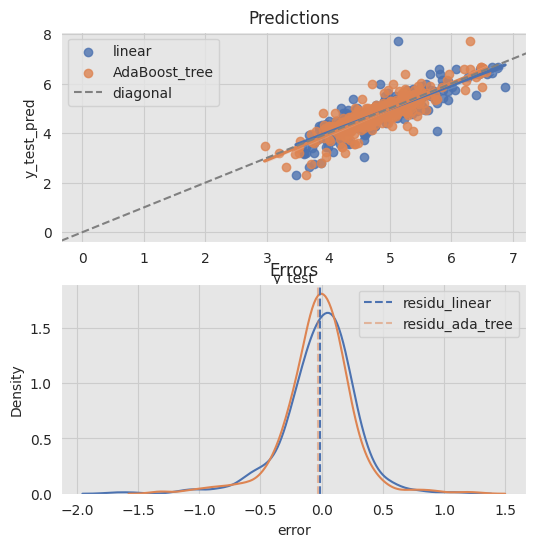

In [120]:
fig, ax = plt.subplots(2,1,figsize = (6,6))

ax = ax.flatten()

sns.regplot(y=y_test, x = linear_y_pred, label='linear', ax=ax[0])
sns.regplot(y=y_test, x = ada_tree_y_pred, label='AdaBoost_tree', ax=ax[0])
ax[0].axline(xy1=(0,0), slope=1, color='gray', linestyle='--', label='diagonal')
ax[0].legend(loc='upper left')
ax[0].set(title='Predictions', xlabel='y_test', ylabel='y_test_pred')


x = residu_linear[residu_linear < np.quantile(residu_linear, 1)]
sns.kdeplot(x = x, ax  = ax[1])
x = residu_ada_tree[residu_ada_tree < np.quantile(residu_ada_tree, 1)]
sns.kdeplot(x = x, ax  = ax[1])
ax[1].axvline(x=residu_linear.mean(), color=sns.color_palette()[0], linestyle='--', label='residu_linear')
ax[1].axvline(x=residu_ada_tree.mean(), color=sns.color_palette()[1], linestyle='--', label='residu_ada_tree', alpha = 0.5)
ax[1].legend(loc='upper right')
ax[1].set(title='Errors', xlabel= 'error')

plt.show()

#### Graphique

https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc

In [95]:
#extraction des variables explicatives apres transformation
modele_features = modele[:-1].get_feature_names_out()
len(modele_features)

50

In [106]:
tree_adaboost_grid_search.best_params_

{'regressor__base_estimator__max_depth': 50,
 'regressor__base_estimator__min_samples_leaf': 1,
 'regressor__learning_rate': 1,
 'regressor__n_estimators': 30}

In [107]:
from sklearn.tree import plot_tree

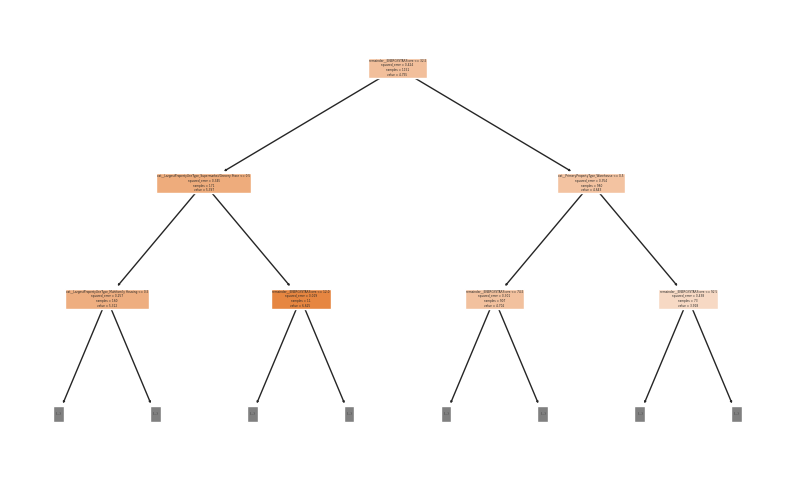

In [108]:
plt.figure()
plot_tree(ada_tree[-1][0], feature_names = modele_features, max_depth =2, filled=True)
plt.show()

## 3.3 Permutation Importance

In [109]:
from sklearn.inspection import permutation_importance

In [110]:
adaboost_tree_pi = permutation_importance(
    estimator=ada_tree,
    X=X_train,
    y=y_train,
    n_repeats=10
)
#retourn a dictionnary with 3 keys :('importances_mean', 'importances_std','importances')
adaboost_tree_pi['importances'].shape

(12, 10)

In [111]:
adaboost_tree_pi.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [112]:
adaboost_tree_pi['importances_mean']

array([0.01175086, 0.01435352, 0.00242107, 0.03054352, 0.01971098,
       0.05918452, 0.13894452, 0.04112841, 0.01124315, 0.81832513,
       0.20405379, 0.31732687])

In [113]:
X_train.columns.shape

(12,)

In [114]:
d = {'importances_mean':adaboost_tree_pi['importances_mean'],'importances_std':adaboost_tree_pi['importances_std']}
adaboost_tree_pi_df= pd.DataFrame(data = d,
                          index =X_train.columns )

In [115]:
adaboost_tree_pi_df = adaboost_tree_pi_df.sort_values(by ='importances_mean', ascending= False)

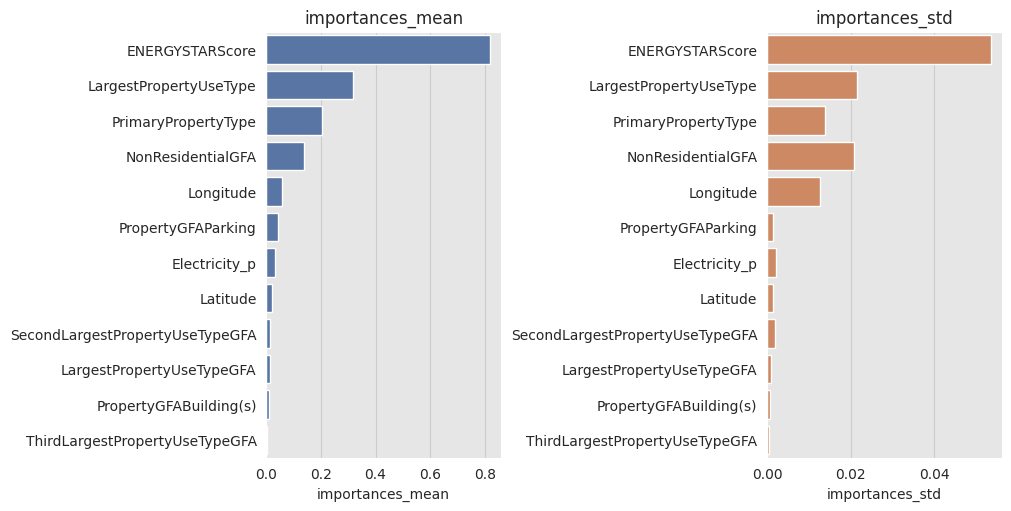

In [116]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), constrained_layout=True)

sns.barplot(
    data = adaboost_tree_pi_df,
    x='importances_mean',
    y=adaboost_tree_pi_df.index,
    orient='h',
    color=sns_c[0],
    ax=ax[0])

sns.barplot(
    data = adaboost_tree_pi_df,
    x='importances_std',
    y=adaboost_tree_pi_df.index,
    orient='h',
    color=sns_c[1],
    ax=ax[1]
)

ax[0].set(title='importances_mean')
ax[1].set(title='importances_std')

plt.show()

In [122]:
x_train_preprocessor= tree_preprocessor.transform(X_train).todense()
x_train_preprocessor=np.asarray(x_train_preprocessor)

/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/yellowbrick/regressor/influence.py:157: RuntimeWarning: invalid value encountered in sqrt
  residuals_studentized = residuals / np.sqrt(mse) / np.sqrt(1 - leverage)


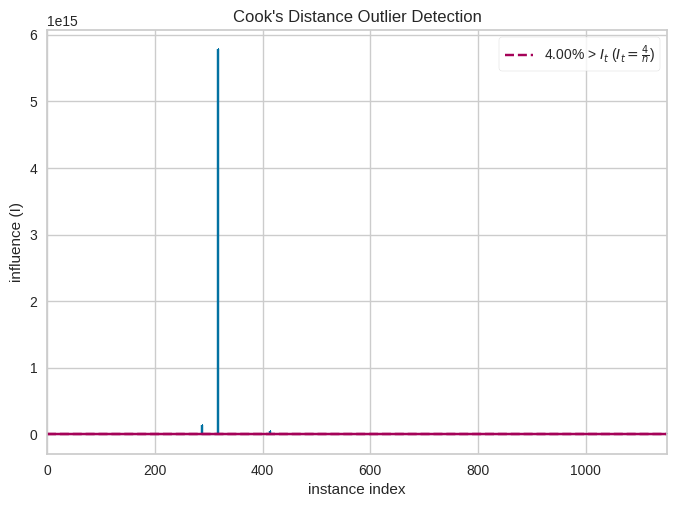

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [123]:
from yellowbrick.regressor import CooksDistance
from yellowbrick.datasets import load_concrete



# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(x_train_preprocessor,np.asarray(y_train))
visualizer.show()

In [124]:
cook_distance = pd.Series(visualizer.distance_)
cook_distance = cook_distance.sort_values(ascending = False)

In [126]:
X_train.iloc[cook_distance[:4].index][['Electricity_p','ENERGYSTARScore','LargestPropertyUseType']]

,Electricity_p,ENERGYSTARScore,LargestPropertyUseType
887,0.515056,80.0,Distribution Center
1233,1.000000,60.0,Bank Branch
440,0.748053,75.0,Retail Store
529,0.689684,89.0,Other


## 3.4 Interpretation 

### Globale

In [ ]:
import shap

In [ ]:
shap_values = shap.TreeExplainer(modele[-1]).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")